# 2 qubit GST for XYICZ gate: Testing random sequence constructions

In [1]:
# Note: I removed the mGST folders from within the qibocal fork, such that it is installed and updated seperately
from mGST import compatibility,algorithm, optimization, low_level_jit, additional_fns

In [2]:
import pickle as pickle
from pygsti.report import reportables as rptbl #Needs cvxpy!
import pygsti
from argparse import Namespace
import numpy as np
import pandas as pd
import numpy.linalg as la
import json
import matplotlib.pyplot as plt
from random import sample
#from pygsti.modelpacks import smq2Q_XYICNOT as std

%run ../src/mGST/reporting.py

### Setting the parameters

In [3]:
pdim = 4   # physical dimension
r = pdim**2   # rank of the gate superoperators 

max_l = 10  # maximum number of gates in each measurement sequence
n_povm = 4   # number of POVM-elements
d = 6

In [4]:
from true_values import E_true, X_true, rho_true
X_t = X_true[:d].copy()
E_t = E_true.copy()
rho_t = rho_true.copy()
target_mdl = compatibility.arrays_to_pygsti_model(X_t,E_t,rho_t, basis = 'std')
noisy_mdl = compatibility.arrays_to_pygsti_model(X_t,E_t,rho_t, basis = 'std').depolarize(0.001,spam_noise=0.05).randomize_with_unitary(0.01)
X_noisy, E_noisy, rho_noisy = compatibility.pygsti_model_to_arrays(noisy_mdl, basis = 'std')

### Generating data

In [5]:
def random_len_seq_2(d,min_l,max_l,N):
    seq_lengths = np.sort(np.random.randint(min_l,max_l+1,N))
    J = []
    for l in seq_lengths:
        j_curr = np.random.randint(0,d,l)
        J.append(list(np.pad(j_curr,(0,max_l-l),'constant',constant_values=-1)))
    return np.array(J)

def random_len_seq_3(d,min_l,max_l,N): #Draws without replacement but inneficiently (not working for sequences length > 24)
    seq_counts = []
    J = [-np.ones(max_l)]
    N_remaining = N - 1
    for l in range(min_l,max_l+1):
        seq_counts.append(int(np.min([np.floor(N_remaining/(max_l+1-l)), d**l])))
        ind_curr = np.array(sample(range(d**l), seq_counts[-1]))
        J_curr = np.array([np.pad(low_level_jit.local_basis(ind,d,l),(0,max_l-l),'constant', constant_values = -1) for ind in ind_curr])
        J = np.concatenate((J,J_curr), axis = 0)
        N_remaining = N - 1 - np.sum(seq_counts)
    if N_remaining > 0:
        print('Number of possible sequences without replacement for the given sequence\
        length range is lower than the desired total number of sequences')
    return J.astype(int)

In [35]:
J = random_len_seq_3(d,1,8,500)

In [36]:
print(J.shape)

(500, 8)


In [11]:
l_min = 1
l_cut = 8
l_max = 24
N = 500
N_long = 300
meas_samples = 1e5
J = random_len_seq_3(d,l_min,l_cut,N)
J2 = random_len_seq_3(d,l_cut,l_max,N_long)

y = np.real(np.array([[E_noisy[i].conj()@low_level_jit.contract(X_noisy,j)@rho_noisy for j in J] for i in range(n_povm)]))
y = additional_fns.sampled_measurements(y,meas_samples).copy()

y2 = np.real(np.array([[E_noisy[i].conj()@low_level_jit.contract(X_noisy,j)@rho_noisy for j in J2] for i in range(n_povm)]))
y2 = additional_fns.sampled_measurements(y2,meas_samples).copy()

In [12]:
max_l_drawn = np.max(np.sum(J2>=0,axis = 1))
print(max_l_drawn)
J_all = []
for i in range(N):
    J_all.append(list(np.pad(J[i],(0,max_l_drawn-len(J[i])),'constant',constant_values=-1)))
for i in range(N_long):
    J_all.append(list(np.pad(J2[i],(0,max_l_drawn-len(J2[i])),'constant',constant_values=-1)))
J_all = np.array(J_all)

J_reduced = []
for i in range(N):
    J_reduced.append(list(J[i,:][J[i,:]>=0]))
for i in range(N_long):
    J_reduced.append(list(J2[i,:][J2[i,:]>=0]))
y_all = np.concatenate((y,y2), axis = 1)

24


In [49]:
print(y_all.shape)

(4, 700)


In [13]:
import csv

with open('sequences.csv', 'w', newline='') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerows(J_reduced)

### GST

Starting optimization...
100%|█████████████████████████████████████████| 180/180 [04:26<00:00,  1.48s/it]


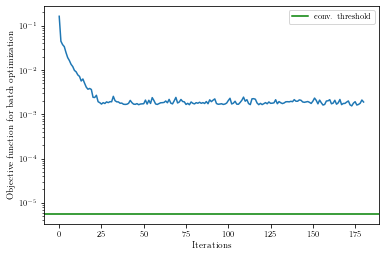

Run  0 failed, trying new initialization...
100%|█████████████████████████████████████████| 180/180 [04:24<00:00,  1.47s/it]


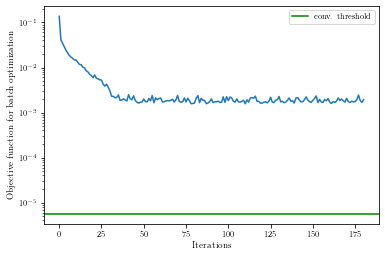

Run  1 failed, trying new initialization...
100%|█████████████████████████████████████████| 180/180 [04:24<00:00,  1.47s/it]


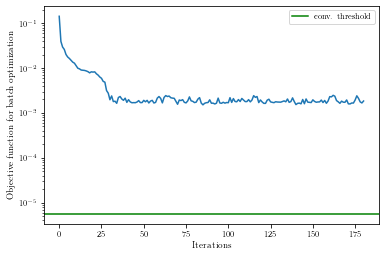

Run  2 failed, trying new initialization...
 32%|█████████████▌                            | 58/180 [01:27<03:03,  1.50s/it]


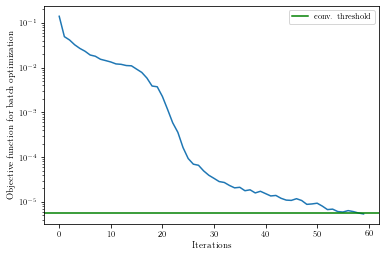

Initialization successful, improving estimate over full data....
100%|███████████████████████████████████████████| 30/30 [02:30<00:00,  5.01s/it]


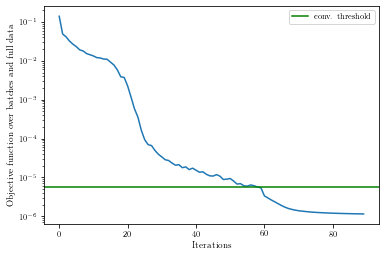

#################
	 Convergence criterion satisfied
	 Final objective function value 1.1485811723335245e-06 with # of initializations: 4 
 	 Total runtime: 1035.6270604133606
Starting optimization...
100%|███████████████████████████████████████████| 30/30 [11:14<00:00, 22.50s/it]


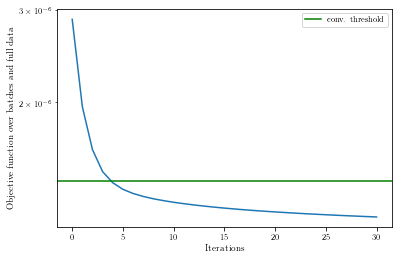

#################
	 Convergence criterion satisfied
	 Final objective function value 1.2114198504608238e-06 with # of initializations: 1 
 	 Total runtime: 677.9342319965363


In [52]:
bsize = 120   # The batch size on which the optimization is started
results = []
rK = 2
for _ in range(1):  
    K_t = additional_fns.Kraus_rep(X_t,d,pdim,rK)
    K,X,E,rho,res_list = algorithm.run_mGST(y, J, max_l,d,r,rK, n_povm, bsize, meas_samples, method = 'SFN',
                         max_inits = 10, max_iter = 180, final_iter = 30, threshold_multiplier = 4, 
                         target_rel_prec = 1e-4, testing = True)   
    K2,X2,E2,rho2,res_list2 = algorithm.run_mGST(y_all,J_all, max_l,d,r,rK, n_povm, bsize, meas_samples, method = 'SFN',
                         max_inits = 10, max_iter = 0, final_iter = 30, threshold_multiplier = 1, 
                         target_rel_prec = 1e-4, init = [K,E,rho], testing = True)   
    results.append([K,X,E,rho])

Starting optimization...
100%|███████████████████████████████████████████| 50/50 [18:40<00:00, 22.41s/it]


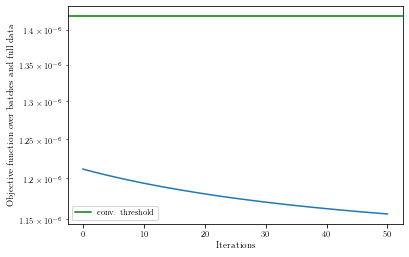

#################
	 Convergence criterion satisfied
	 Final objective function value 1.1562095223952007e-06 with # of initializations: 1 
 	 Total runtime: 1128.3079965114594


In [55]:
K3,X3,E3,rho3,res_list3 = algorithm.run_mGST(y_all,J_all, max_l,d,r,rK, n_povm, bsize, meas_samples, method = 'SFN',
                     max_inits = 10, max_iter = 0, final_iter = 50, threshold_multiplier = 1, 
                     target_rel_prec = 1e-5, init = [K2,E2,rho2], testing = True)   

In [53]:
K,X,E,rho = results[0][:]

weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 1, 'rho0': 0}
gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CZ[q0-q1]"}

X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, target_mdl, weights)
df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J, y, target_mdl, gate_labels)
display(s_g), display(s_o)


df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J, y, noisy_mdl, gate_labels)
display(s_g), display(s_o)


,F_avg,Diamond distances,Min. Spectral distances
Id,"0,99767","0,04680","0,04045"
Rx(pi/2)[q0],"0,20003","1,00000","0,04614"
Ry(pi/2)[q0],"0,99787","0,04913","0,03584"
Rx(pi/2)[q1],"0,20013","1,00000","0,02735"
Ry(pi/2)[q1],"0,99827","0,02494","0,01528"
CZ[q0-q1],"0,99733","0,04145","0,03294"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000001,0.001607,0.047674,0.030794,0.019147


,F_avg,Diamond distances,Min. Spectral distances
Id,"0,99562","0,07734","0,00089"
Rx(pi/2)[q0],"0,20018","0,99988","0,00091"
Ry(pi/2)[q0],"0,99712","0,05811","0,00096"
Rx(pi/2)[q1],"0,20048","0,99984","0,00104"
Ry(pi/2)[q1],"0,99763","0,04231","0,00157"
CZ[q0-q1],"0,99460","0,08546","0,00175"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000001,0.001607,0.001682,0.030794,0.043697


(None, None)

In [54]:
weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 1, 'rho0': 0}
gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CZ[q0-q1]"}

X_opt, E_opt, rho_opt = gauge_opt(X2, E2, rho2, target_mdl, weights)
df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J, y, target_mdl, gate_labels)
display(s_g), display(s_o)


df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J, y, noisy_mdl, gate_labels)
display(s_g), display(s_o)


,F_avg,Diamond distances,Min. Spectral distances
Id,"0,99825","0,04667","0,04047"
Rx(pi/2)[q0],"0,20009","1,00000","0,04545"
Ry(pi/2)[q0],"0,99829","0,04873","0,03540"
Rx(pi/2)[q1],"0,20010","1,00000","0,02681"
Ry(pi/2)[q1],"0,99886","0,02460","0,01546"
CZ[q0-q1],"0,99845","0,04092","0,03221"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000001,0.001628,0.047674,0.031704,0.018352


,F_avg,Diamond distances,Min. Spectral distances
Id,"0,99607","0,07733","0,00046"
Rx(pi/2)[q0],"0,20030","0,99986","0,00026"
Ry(pi/2)[q0],"0,99743","0,05770","0,00032"
Rx(pi/2)[q1],"0,20041","0,99986","0,00044"
Ry(pi/2)[q1],"0,99809","0,04204","0,00046"
CZ[q0-q1],"0,99550","0,08460","0,00040"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000001,0.001628,0.001682,0.031704,0.043240


(None, None)

In [56]:
weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 1, 'rho0': 0}
gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CZ[q0-q1]"}

X_opt, E_opt, rho_opt = gauge_opt(X3, E3, rho3, target_mdl, weights)
df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J, y, target_mdl, gate_labels)
display(s_g), display(s_o)


df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J, y, noisy_mdl, gate_labels)
display(s_g), display(s_o)


,F_avg,Diamond distances,Min. Spectral distances
Id,"0,99824","0,04662","0,04041"
Rx(pi/2)[q0],"0,20020","1,00000","0,04548"
Ry(pi/2)[q0],"0,99826","0,04885","0,03539"
Rx(pi/2)[q1],"0,20009","1,00000","0,02685"
Ry(pi/2)[q1],"0,99889","0,02462","0,01546"
CZ[q0-q1],"0,99844","0,04118","0,03221"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000001,0.001617,0.047674,0.031714,0.018311


,F_avg,Diamond distances,Min. Spectral distances
Id,"0,99606","0,07735","0,00047"
Rx(pi/2)[q0],"0,20048","0,99984","0,00031"
Ry(pi/2)[q0],"0,99741","0,05768","0,00028"
Rx(pi/2)[q1],"0,20038","0,99986","0,00045"
Ry(pi/2)[q1],"0,99811","0,04202","0,00040"
CZ[q0-q1],"0,99550","0,08463","0,00035"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000001,0.001617,0.001682,0.031714,0.043217


(None, None)